Sections 1 needs to be run in all cases to retrain the model (very quick). 

Section 2 calculates the hold-out likelihood.

Section 3 is for generating data.

In [1]:
import numpy as np
import sklearn
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.optimize
from scipy.stats import norm
import seaborn as sns


In [2]:
k = 8
J = 32
save_time_step = 0.005
h=1 
F=20
c=10
b=10

# 1: Get data and train model #

In [3]:
x_train = np.load("../../data/truth_run/training_dataset.npy")

In [4]:
x = x_train[:,:,0]

In [5]:
u_t = -np.roll(x[:-1,:],1,axis=1) * (np.roll(x[:-1,:],2,axis=1) - np.roll(x[:-1,:],-1,axis=1)) - x[:-1,:] + F -(x[1:,:] - x[:-1,:])/save_time_step

In [6]:
x_t_ravel = np.ravel(x[:-1,:]).reshape(-1,1)
u_t_ravel = np.ravel(u_t).reshape(-1,1)

In [7]:
poly = PolynomialFeatures(degree=3,include_bias=True)

In [8]:
x_t_poly = poly.fit_transform(x_t_ravel)

In [9]:
reg = LinearRegression(fit_intercept=False)

In [10]:
reg.fit(x_t_poly,u_t_ravel)

LinearRegression(fit_intercept=False)

In [11]:
reg.coef_

array([[ 0.34484477,  1.29971787, -0.01271022, -0.00238594]])

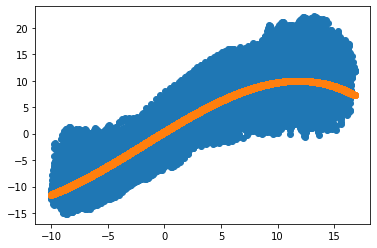

In [12]:
plt.figure()
plt.scatter(x=np.ravel(x[:-1,:]),y=np.ravel(u_t))
plt.scatter(x=np.ravel(x[:-1,:]),y=reg.predict(x_t_poly))
plt.show()

#plot of u vs x

In [18]:
u_t_pred = reg.predict(x_t_poly).reshape(-1,k)

In [19]:
residual =  u_t - u_t_pred

In [20]:
h_t = np.ravel(residual[1:,:])
h_t_minus1 = np.ravel(residual[:-1,:])

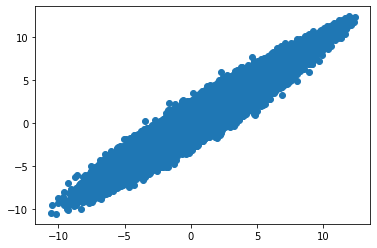

In [21]:
plt.scatter(x=np.ravel(h_t_minus1),y=np.ravel(h_t))

In [15]:
# need to find optimum sigma and phi values. Model as normally distributed variable h_t, and then maximise loglik

def loglik(h_t,h_t_minus1,theta):
    tau,rho = theta
    sigma = np.exp(tau) # ensures sigma is positive
    phi = np.exp(rho) / (1+ np.exp(rho)) #ensures phi is between 0 and 1
    lik = norm.pdf(h_t,loc=phi*h_t_minus1,scale=sigma*(1-phi**2)**0.5)
    return np.log(lik)

In [16]:
initial_guess = [0.7,4]

In [17]:
theta_mle = scipy.optimize.fmin(lambda theta: -np.sum(loglik(h_t,h_t_minus1,theta)), initial_guess, maxiter=5000)

Optimization terminated successfully.
         Current function value: 1057200.577661
         Iterations: 33
         Function evaluations: 66


In [18]:
theta_mle

array([0.69118557, 4.2303411 ])

In [19]:
phi = np.exp(theta_mle[1]) / (1+np.exp(theta_mle[1]))
phi

0.9856611655437044

In [20]:
sigma = np.exp(theta_mle[0])
sigma

1.996080629655475

# 2: Evaluate hold-out data log-likelihood #

In [12]:
def _rhs_X_dt(X, F,U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,F,dt=0.005):
    k1_X = _rhs_X_dt(Xt,F,U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2,F, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut


def avg_loglikelihood_proper_generation_method(climate_eval_dataset,F,sigma=1.99608,phi=0.98566,dt=0.005):
    """Shape of climate_eval_dataset is num_steps x k x 2"""
    
    data = climate_eval_dataset[:,:,0] #so we get num_steps x k shape
    
    #we now need to work out the actual epsilon from each step
    
    u_t = U(data[:-1,:],data[1:,:],F)    
    X_poly = poly.fit_transform(data[:-1,:].reshape(-1,1))
    U_d = reg.predict(X_poly).reshape(-1,k)
    h_t = u_t - U_d
    
    #likelihood calculations 
    
    #other terms
    h_time_plus_one = h_t[1:,:]
    h_time = h_t[:-1,:]
    
    term1 = norm.logpdf(h_time[:1,:],loc=0,scale=sigma) -np.log(dt) #scaling factor
    
    loglik_rest = norm.logpdf(h_time_plus_one,loc=phi*h_time,scale=sigma*(1-phi**2)**0.5) -np.log(dt) #scaling factor
    
    loglik_full = np.concatenate([term1,loglik_rest],axis=0)
    
    #combine
    return np.mean(loglik_full)

    

## F = 20 ##

In [13]:
test_set = np.load("../../data/truth_run/climate_eval_dataset.npy")

In [14]:
test_set.shape

(2000001, 8, 2)

In [19]:
#10000 MTU
avg_loglikelihood_proper_generation_method(test_set,F=20)

4.976354044985707

## F = 23 data ##

In [20]:

test_set_23 = np.load("../../data/truth_run/climate_change_exp/full_test_set.npy")

In [98]:
#10000 MTU
avg_loglikelihood_proper_generation_method(test_set_23,F=23)

4.7276309132474985

## F = 28 data ##

In [22]:

test_set_28 = np.load("../../data/truth_run/climate_change_exp/full_28_set.npy")[:int(10000/0.005)]

In [23]:
#10000 MTU
avg_loglikelihood_proper_generation_method(test_set_28,F=28)

4.050082941185682

# 3: Generate data using this parameterisation #

This is done and saved in consecutive chunks for computational reasons (prevent kernel dying).

In [34]:
def simulate_polynomial_param(initX,num_steps, sigma = 1.99608,phi =0.98566 ,F=20,dt=0.005):
    
    "num steps is #MTU/0.005"
    
    def _rhs_X_dt(X, U):
        """Compute the right hand side of the X-ODE."""

        dXdt = (-np.roll(X, 1) * (np.roll(X, 2) - np.roll(X, -1)) -
                    X + F - U)
            
        return dt * dXdt 
    
    def sub_grid_u_term(X,array_h):
        h_t_minus1 = array_h
        X_poly = poly.fit_transform(X.reshape(-1,1))
        U_d = reg.predict(X_poly)
        z = np.random.normal(size=(k,1))
        h_t = phi*h_t_minus1 + sigma*((1-phi**2)**0.5)*z
        U_pred = U_d + h_t
        return U_pred.reshape(k),h_t
    
    
    def step(X_in,array_h):
        """Integrate one time step"""
        X = X_in.copy()
        k1_X = _rhs_X_dt(X, U=0)
        k2_X = _rhs_X_dt(X + k1_X / 2, U=0)

        U,h_t = sub_grid_u_term(X,array_h) ######
        
        X += k2_X
        
        X += - U * dt
        return X,h_t
        
    
    array = np.zeros(shape=(k,num_steps))
    array[:,0] = initX
    
    #array_h = np.zeros(shape=(k,1))
    array_h = sigma*np.random.normal(size=(k,1)) 
    
    for i in range(num_steps-1):
        X_new, h_new = step(array[:,i],array_h)
        array[:,i+1] = X_new
        array_h = h_new
        
    return array

# can output last hidden state too to feed into the next arrays

The cell below is an example of how data is generated. The actual code used to generate all the data is commented out in the F=20 and F=23 sections below.

In [ ]:
#example of generating data 

x_climate = np.load("../../data/truth_run/climate_eval_dataset.npy")

init_X_climate = x_climate[0,:,0]

num_steps_climate = int(1/0.005) #1 MTU of data

data = simulate_polynomial_param(init_X_climate,num_steps_climate,sigma = 1.99608,phi =0.98566 ,F=20,dt=0.005)

## F = 20 ##

In [23]:
# x_climate = np.load("../../data/truth_run/climate_eval_dataset.npy")
# init_X_climate = x_climate[0,:,0]
# num_steps_climate = int(10002/0.005) 
# x_array_climate = simulate_polynomial_param(init_X_climate,num_steps_climate)
# np.save("../../data/simulation_runs/polynomial_param/climate_eval_dataset.npy",x_array_climate)

# init_X_extra = x_array_climate[:,-1]
# x_array_extra = simulate_polynomial_param(init_X_extra,num_steps_climate)[:,1:]
# np.save("../../data/simulation_runs/polynomial_param/extra_dataset.npy",x_array_extra)

# init_X_extra2 = x_array_extra[:,-1]
# x_array_extra2 = simulate_polynomial_param(init_X_extra2,num_steps_climate)[:,1:]
# np.save("../../data/simulation_runs/polynomial_param/extra_dataset2.npy",x_array_extra2)



# ##### and so on##############


## Climate change F = 23 ## 

In [21]:
# test_set_climate = np.load("../../data/truth_run/climate_change_exp/full_test_set.npy")
# init_X_clim_test = test_set_climate[0,:,0]
# num_steps_test = int(10002/0.005) #last part is 2MTU burn in 

# x_array_test = simulate_polynomial_param(init_X_clim_test,num_steps_test,sigma = 1.99608,phi =0.98566 ,F=23,dt=0.005)
# np.save("../../data/simulation_runs/polynomial_param/climate_change/climate_change_exp_test_f_23.npy",x_array_test)

# init_X_extra = x_array_test[:,-1]
# x_array_extra = simulate_polynomial_param(init_X_extra,num_steps_test,sigma = 1.99608,phi =0.98566 ,F=23,dt=0.005)[:,1:]
# np.save("../../data/simulation_runs/polynomial_param/climate_change/extra_dataset_a.npy",x_array_extra)

# init_X_extra2 = x_array_extra[:,-1]
# x_array_extra2 = simulate_polynomial_param(init_X_extra2,num_steps_test,sigma = 1.99608,phi =0.98566 ,F=23,dt=0.005)[:,1:]
# np.save("../../data/simulation_runs/polynomial_param/climate_change/extra_dataset2_a.npy",x_array_extra2)

# ######### and so on ##########


## Weather analysis ##

In [31]:
truth_weather = np.load("../../data/truth_run/weather_experiments/weather_array_longer.npy")

In [32]:
truth_weather_init_conditions = truth_weather[:,0,:]
num_init_conds = truth_weather.shape[0]
length_simulations = truth_weather.shape[1]
num_ensemble_members = 40

In [33]:
def simulate_polynomial_param_weather(starting_condition,num_steps,num_ensemble_members=40,
                                      sigma = 1.99608,phi =0.98566 ,F=20,dt=0.005):
    
    
    def _rhs_X_dt(X, U):
        """Compute the right hand side of the X-ODE."""

        dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                    X + F - U)
            
        return dt * dXdt 
    
    def sub_grid_u_term(X,array_h):
        h_t_minus1 = array_h
        X_poly = poly.fit_transform(X.reshape(-1,1))
        U_d = reg.predict(X_poly).reshape(-1,k)
        z = np.random.normal(size=(length,k))
        U_pred = U_d + h_t_minus1
        h_t = phi*h_t_minus1 + sigma*((1-phi**2)**0.5)*z
        return U_pred,h_t
    
    
    def step(X_in,array_h):
        """Integrate one time step"""
        X = X_in.copy()
        k1_X = _rhs_X_dt(X, U=0)
        k2_X = _rhs_X_dt(X + k1_X / 2, U=0)

        U,h_t = sub_grid_u_term(X,array_h) ######
        
        X += k2_X
        
        X += - U * dt
        return X,h_t
        
        
    #np.random.seed(42)
    initX = starting_condition.repeat(num_ensemble_members,axis=0)  
    
    length = initX.shape[0]
    
    array = np.zeros(shape=(length,k,num_steps))
    array[:,:,0] = initX
    
    array_h = sigma*np.random.normal(size=(length,k)) 
    
    for i in range(num_steps-1):
        print(i)
        X_new, h_new = step(array[:,:,i],array_h)
        array[:,:,i+1] = X_new
        array_h = h_new
        
    return array.reshape(starting_condition.shape[0],num_ensemble_members,k,num_steps)

In [29]:
truth_weather_init_conditions.shape

(745, 8)

In [58]:
array = simulate_polynomial_param_weather(truth_weather_init_conditions,length_simulations)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
np.save("../../data/simulation_runs/polynomial_param/weather_experiments/weather_array_longer.npy",array)